In [1]:
import psycopg2

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import matplotlib.cm as cm

# This group is a result of grouping the multiclient experiments.
try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="multiclientdb", password="coap", application_name="notebook")
  con.set_session(readonly=True, autocommit=True)

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*,
	d.dnid,
	n.*
FROM
	experiment ex
	JOIN deployed_node d ON d.exp_id = ex.exp_id
	JOIN node n ON d.node_id = n.node_id
GROUP BY
	ex.exp_id,
	n.node_id,
	d.dnid
ORDER BY
	ex.attacker_rate,
	ex.num_proxy_connections
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
print()
lay_of_the_land

multiclient_cloud_500mbps_attack_noattacker_dtlson
multiclient_cloud_500mbps_attack_noattacker
multiclient_cloud_500mbps_attack_noattacker_httpson
multiclient_cloud_500mbps_attack_noattacker_dtlson_httpson
multiclient_cloud_500mbps_attack_withattacker_httpson
multiclient_cloud_500mbps_attack_withattacker
multiclient_cloud_500mbps_attack_withattacker_dtlson_httpson
multiclient_cloud_500mbps_attack_withattacker_dtlson
multiclient_cloud_500mbps_attack_withattacker_dtlson_100conns

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 15.6 ms


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,dnid,node_id,node_name,hardware_type,operating_system
0,multiclient_cloud_500mbps_attack_noattacker_dt...,0mbps,256,0,3,3,120,20,120,120,...,1,True,True,False,False,6,2,client1,microcloud,ubuntu1804-std
1,multiclient_cloud_500mbps_attack_noattacker,0mbps,256,0,3,3,120,20,120,120,...,1,True,False,False,False,63,7,receiver,microcloud,ubuntu1804-std
2,multiclient_cloud_500mbps_attack_noattacker,0mbps,256,0,3,3,120,20,120,120,...,1,True,False,False,False,62,6,proxy,microcloud,ubuntu1804-std
3,multiclient_cloud_500mbps_attack_noattacker_ht...,0mbps,256,0,3,3,120,20,120,120,...,1,True,False,True,False,44,2,client1,microcloud,ubuntu1804-std
4,multiclient_cloud_500mbps_attack_noattacker_dt...,0mbps,256,0,3,3,120,20,120,120,...,1,True,True,True,False,27,6,proxy,microcloud,ubuntu1804-std
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,multiclient_cloud_500mbps_attack_withattacker_...,500mbps,256,0,3,3,120,20,120,120,...,1,True,False,True,True,42,7,receiver,microcloud,ubuntu1804-std
59,multiclient_cloud_500mbps_attack_withattacker_...,500mbps,256,0,3,3,120,20,120,120,...,1,True,False,True,True,37,2,client1,microcloud,ubuntu1804-std
60,multiclient_cloud_500mbps_attack_withattacker_...,500mbps,256,0,3,3,120,20,120,120,...,1,True,False,True,True,38,3,client2,microcloud,ubuntu1804-std
61,multiclient_cloud_500mbps_attack_withattacker_...,500mbps,256,0,3,3,120,20,120,120,...,1,True,False,True,True,39,4,client3,pc3060,ubuntu1804-std


In [3]:
%%time 

exp_id = "multiclient_cloud_500mbps_attack_withattacker"

df = lay_of_the_land
df = df[(df["exp_id"] == exp_id)]

exp_config = df.head(1).to_dict(orient="records")[0]
run_proxy_with_dtls = exp_config["run_proxy_with_dtls"]

records = df[["node_name", "dnid", "node_id"]].to_records(index=False)

node_map_node_id = dict()
node_map_dnid = dict()
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
proxy_dnid = None
attacker_node_id = None
attacker_dnid = None
attacker_message_receiver_node_id = None
attacker_message_receiver_dnid = None
receiver_node_id = None
receiver_dnid = None

for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
        proxy_dnid = dnid
    elif node_name == 'attacker':
        attacker_node_id = node_id
        attacker_dnid = dnid
    elif node_name == 'receiver':
        receiver_node_id = node_id
        receiver_dnid = dnid
    
dnid_map_node = {d:n for n,d in node_map_dnid.items()}
experiment_dnids = set(dnid_map_node.keys())

if not run_proxy_with_dtls:
  # The attacker regularly exploits IP address spoofing
  # to "purify" its attacking process by forcing all traffic
  # that it sent to go to the receiver
  attacker_message_receiver_node_id = receiver_node_id
  attacker_message_receiver_dnid = receiver_dnid
else:
  # Running with DTLS means the attacker receives
  # all the traffic it sent out, because there is
  # no spoofing with DTLS
  attacker_message_receiver_node_id = attacker_node_id
  attacker_message_receiver_dnid = attacker_dnid
    
print(f"{node_map_node_id=}")
print(f"{node_map_dnid=}")
print(f"{dnid_map_node=}")
print(f"{experiment_dnids=}")
print()
print(f"{client_node_ids=}")
print(f"{client_dnids=}")
print()
print(f"{attacker_message_receiver_node_id=}")
print(f"{attacker_message_receiver_dnid=}")
print()

exp_config

node_map_node_id={'receiver': 7, 'client1': 2, 'client2': 3, 'originserver': 5, 'client3': 4, 'attacker': 1, 'proxy': 6}
node_map_dnid={'receiver': 21, 'client1': 16, 'client2': 17, 'originserver': 19, 'client3': 18, 'attacker': 15, 'proxy': 20}
dnid_map_node={21: 'receiver', 16: 'client1', 17: 'client2', 19: 'originserver', 18: 'client3', 15: 'attacker', 20: 'proxy'}
experiment_dnids={15, 16, 17, 18, 19, 20, 21}

client_node_ids={2, 3, 4}
client_dnids={16, 17, 18}

attacker_message_receiver_node_id=7
attacker_message_receiver_dnid=21

CPU times: user 7.37 ms, sys: 1.4 ms, total: 8.77 ms
Wall time: 8.31 ms


{'exp_id': 'multiclient_cloud_500mbps_attack_withattacker',
 'attacker_rate': '500mbps',
 'server_connections': 256,
 'max_keep_alive_requests': 0,
 'num_clients': 3,
 'num_trials': 3,
 'origin_server_duration': 120,
 'attacker_duration': 20,
 'receiver_duration': 120,
 'proxy_duration': 120,
 'client_duration': 100,
 'attacker_start_lag_duration': 20,
 'topology_name': 'cp_ia_ha',
 'num_proxy_connections': 50,
 'request_timeout': '5',
 'max_retries': 2,
 'keep_alive_duration': '5',
 'request_retry_interval': '1',
 'reuse_connections': True,
 'run_proxy_with_dtls': False,
 'run_proxy_with_https': False,
 'run_attacker': True,
 'dnid': 21,
 'node_id': 7,
 'node_name': 'receiver',
 'hardware_type': 'microcloud',
 'operating_system': 'ubuntu1804-std'}

In [4]:
%%time

summary_sql = f"""
SELECT 
	'{exp_id}' AS exp_id,
	e.observer_id,
	e.trial,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec,
	(SELECT ex.run_proxy_with_dtls FROM experiment ex WHERE ex.exp_id = '{exp_id}') AS run_proxy_with_dtls
FROM  
	event e
WHERE 
	e.observer_id IN ({','.join(map(str, experiment_dnids))})
GROUP BY
	e.observer_id, e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
sdf.observer_id.replace(dnid_map_node, inplace=True)
sdf

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 1.01 s


,exp_id,observer_id,trial,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec,run_proxy_with_dtls
0,multiclient_cloud_500mbps_attack_withattacker,attacker,1,519324,23.721420,43.562080,19.840660,False
1,multiclient_cloud_500mbps_attack_withattacker,attacker,2,512065,23.710376,43.626348,19.915972,False
2,multiclient_cloud_500mbps_attack_withattacker,attacker,3,494855,23.621520,43.536566,19.915046,False
3,multiclient_cloud_500mbps_attack_withattacker,client1,1,2755,0.000000,98.639686,98.639686,False
4,multiclient_cloud_500mbps_attack_withattacker,client1,2,2763,0.000000,98.689026,98.689026,False
5,multiclient_cloud_500mbps_attack_withattacker,client1,3,2757,0.000000,98.603133,98.603133,False
6,multiclient_cloud_500mbps_attack_withattacker,client2,1,2768,1.094695,99.740040,98.645345,False
7,multiclient_cloud_500mbps_attack_withattacker,client2,2,2772,1.075611,99.756779,98.681168,False
8,multiclient_cloud_500mbps_attack_withattacker,client2,3,2774,0.992934,99.702832,98.709898,False
9,multiclient_cloud_500mbps_attack_withattacker,client3,1,2661,4.380214,101.919755,97.539541,False


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


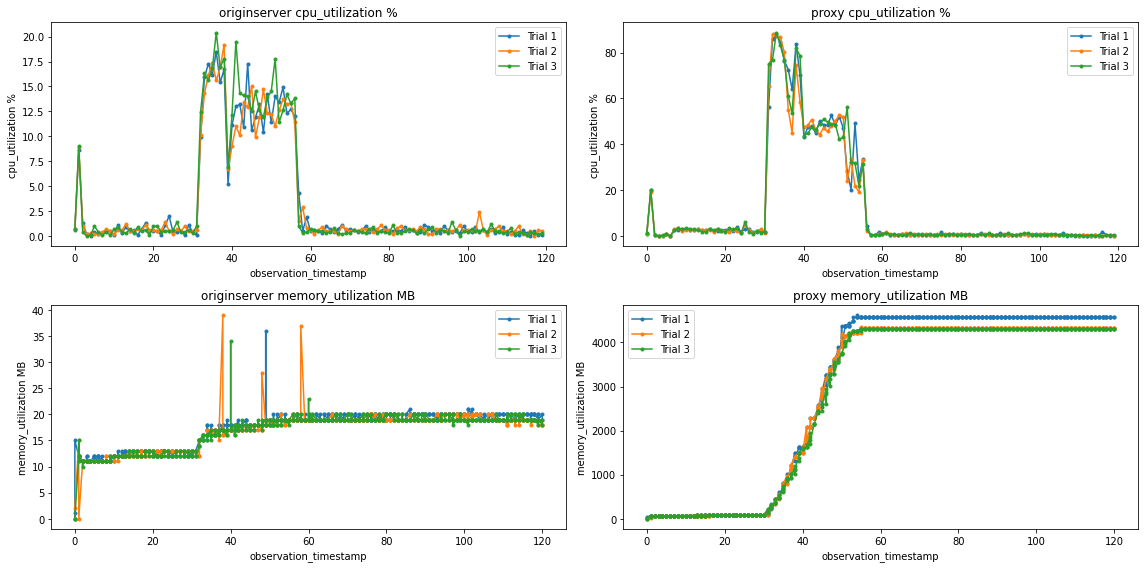

CPU times: user 1.34 s, sys: 277 ms, total: 1.62 s
Wall time: 1.14 s


,observer_id,trial,observation_timestamp,metric_type,metric_value
0,originserver,1,0,cpu_utilization,1.1
1,originserver,1,0,memory_utilization,247.0
2,originserver,1,0,memory_utilization,248.0
3,originserver,1,0,memory_utilization,262.0
4,originserver,1,1,cpu_utilization,9.1
...,...,...,...,...,...
3814,proxy,3,119,memory_utilization,4560.0
3815,proxy,3,119,memory_utilization,4560.0
3816,proxy,3,120,memory_utilization,4559.0
3817,proxy,3,120,memory_utilization,4559.0


In [5]:
%%time

# Plot the node metrics for each device

metrics_sql = f"""
SELECT nm.*
FROM node_metric nm
WHERE nm.observer_id IN ({','.join(map(str, dnid_map_node.keys()))})
ORDER BY nm.observer_id, nm.trial, nm.observation_timestamp, nm.metric_type
"""

metrics_df = pd.read_sql_query(metrics_sql, con)

metrics_df

# Replace dnids with human-readable node names
metrics_df.observer_id.replace(dnid_map_node, inplace=True)

metric_types = metrics_df.metric_type.unique()
node_names = metrics_df.observer_id.unique()
trials = metrics_df.trial.unique()

metric_type_map_extension = {
    "cpu_utilization": "%",
    "memory_utilization": "MB",
}

fig, axs = plt.subplots(len(node_names), len(metric_types))
for i, mt in enumerate(metric_types):
    for j, node_name in enumerate(node_names):
        for t in trials:
            # Filter each metric type observer node into its own tile, further filter by trial
            ax = axs[i, j]
            _df = metrics_df[(metrics_df["metric_type"] == mt) 
                             & (metrics_df["observer_id"] == node_name)
                             & (metrics_df["trial"] == t)]
            
            # Normalize the timestamp and metric value of the experiment
            _df["observation_timestamp"] -= min(_df["observation_timestamp"])
            _df["metric_value"] -= min(_df["metric_value"])
            
            _df.plot(kind="line", x="observation_timestamp", y="metric_value", marker=".", ax=ax, label=f"Trial {t}")

            ylabel = mt + " " + metric_type_map_extension[mt]
            ax.set_ylabel(ylabel)
            ax.set_title(node_name + " " + ylabel)

fig.tight_layout()
plt.show()

metrics_df

In [6]:
%%time

client_messages_sql = f"""
SELECT
	dn.exp_id,
	client_sends.trial,
	client_sends.observer_id,
	client_sends.message_marker,
	MIN(client_sends.observe_timestamp) AS send_time_sec,
	MIN(client_recvs.observe_timestamp) AS recv_time_sec,
	MIN(client_sends.observe_timestamp) AS first_send_time_sec,
	MAX(client_sends.observe_timestamp) AS last_send_time_sec,
	MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
	MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
	1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
	1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
	COUNT(client_sends.*) AS num_send_observations,
	COUNT(client_recvs.*) AS num_recv_observations,
	SUM(CASE WHEN cm_send.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM
	event client_sends
		JOIN message m_sends ON m_sends.message_id = client_sends.message_id
			JOIN coap_message cm_send ON cm_send.cmci = m_sends.coap_message
	JOIN event client_recvs
		ON client_recvs.trial = client_sends.trial
		AND client_recvs.observer_id = client_sends.observer_id
		AND client_recvs.message_marker = client_sends.message_marker
		JOIN message m_recvs ON m_recvs.message_id = client_recvs.message_id
	JOIN deployed_node dn 
		ON (dn.dnid = client_sends.observer_id AND dn.dnid = client_recvs.observer_id)
WHERE
	client_sends.observer_id IN ({','.join(map(str, client_dnids))})     -- clients senders are observers (observer ID)
		AND m_sends.src_id != {proxy_node_id}                            -- proxy is not the sender (node ID)
	AND client_recvs.observer_id IN ({','.join(map(str, client_dnids))}) -- clients receivers are observers (observer ID)
		AND m_recvs.src_id = {proxy_node_id}                             -- proxy is the sender (node ID)
GROUP BY
	dn.exp_id, client_sends.trial, client_sends.observer_id, client_sends.message_marker
ORDER BY
	dn.exp_id, client_sends.trial, client_sends.observer_id, client_sends.message_marker
"""

rtts_df = pd.read_sql_query(client_messages_sql, con)
rtts_df.observer_id.replace(dnid_map_node, inplace=True)

# Compute RTT stats and merge into the df
stats_df = (
  rtts_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    num_messages=("message_marker", pd.Series.nunique),
    global_first_send_time_sec=("send_time_sec", "min"),
    global_last_recv_time_sec=("recv_time_sec", "max"),
  )
  .reset_index()
)
stats_df["average_rps"] = stats_df["num_messages"] / (stats_df["global_last_recv_time_sec"] - stats_df["global_first_send_time_sec"])
rtts_df = rtts_df.merge(stats_df, on=["exp_id", "trial", "observer_id"])

rtts_df

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


CPU times: user 187 ms, sys: 13.1 ms, total: 200 ms
Wall time: 428 ms


,exp_id,trial,observer_id,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
0,multiclient_cloud_500mbps_attack_withattacker,1,client1,1,0.000000,0.149068,0.000000,0.000000,0.149068,0.149068,149.067879,149.067879,1,1,0,1375,0.00000,98.639024,13.939716
1,multiclient_cloud_500mbps_attack_withattacker,1,client1,2,0.164531,0.222032,0.164531,0.164531,0.222032,0.222032,57.500839,57.500839,1,1,0,1375,0.00000,98.639024,13.939716
2,multiclient_cloud_500mbps_attack_withattacker,1,client1,3,0.224358,0.281186,0.224358,0.224358,0.281186,0.281186,56.828022,56.828022,1,1,0,1375,0.00000,98.639024,13.939716
3,multiclient_cloud_500mbps_attack_withattacker,1,client1,4,0.283624,0.339105,0.283624,0.283624,0.339105,0.339105,55.480957,55.480957,1,1,0,1375,0.00000,98.639024,13.939716
4,multiclient_cloud_500mbps_attack_withattacker,1,client1,5,0.341516,0.397237,0.341516,0.341516,0.397237,0.397237,55.720806,55.720806,1,1,0,1375,0.00000,98.639024,13.939716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,multiclient_cloud_500mbps_attack_withattacker,3,client3,498971,101.561185,101.614667,101.561185,101.561185,101.614667,101.614667,53.482056,53.482056,1,1,0,1328,4.41761,101.831288,13.632582
12257,multiclient_cloud_500mbps_attack_withattacker,3,client3,498972,101.615167,101.668633,101.615167,101.615167,101.668633,101.668633,53.466082,53.466082,1,1,0,1328,4.41761,101.831288,13.632582
12258,multiclient_cloud_500mbps_attack_withattacker,3,client3,498973,101.669128,101.722598,101.669128,101.669128,101.722598,101.722598,53.470135,53.470135,1,1,0,1328,4.41761,101.831288,13.632582
12259,multiclient_cloud_500mbps_attack_withattacker,3,client3,498974,101.723261,101.776838,101.723261,101.723261,101.776838,101.776838,53.577185,53.577185,1,1,0,1328,4.41761,101.831288,13.632582


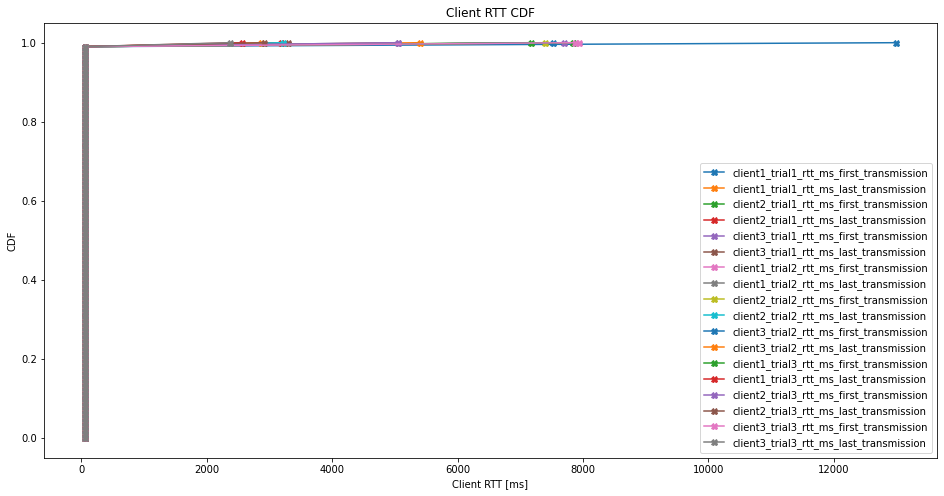

,percentile,trial,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
count,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.00000,101.000000,1.010000e+02
mean,0.500000,3.0,369634.019802,59.348141,59.442389,59.348141,59.372034,59.442389,59.442389,131.063746,76.567771,1.019802,1.019802,0.019802,1328.0,4.41761,101.831288,1.363258e+01
std,0.293002,0.0,218337.246346,30.318212,30.300448,30.318212,30.307258,30.300448,30.300448,778.152149,230.474577,0.199007,0.199007,0.199007,0.0,0.00000,0.000000,3.570433e-15
min,0.000000,3.0,140.000000,4.417610,4.472019,4.417610,4.417610,4.472019,4.472019,52.891970,52.891970,1.000000,1.000000,0.000000,1328.0,4.41761,101.831288,1.363258e+01
25%,0.250000,3.0,1156.250000,23.016675,23.070620,23.016675,23.016675,23.070620,23.070620,53.410769,53.410769,1.000000,1.000000,0.000000,1328.0,4.41761,101.831288,1.363258e+01
50%,0.500000,3.0,497026.500000,65.867561,65.921043,65.867561,65.867561,65.921043,65.921043,53.506017,53.506017,1.000000,1.000000,0.000000,1328.0,4.41761,101.831288,1.363258e+01
75%,0.750000,3.0,498033.750000,83.841112,83.894716,83.841112,83.841112,83.894716,83.894716,53.794980,53.794980,1.000000,1.000000,0.000000,1328.0,4.41761,101.831288,1.363258e+01
max,1.000000,3.0,498975.000000,101.777812,101.831288,101.777812,101.777812,101.831288,101.831288,7873.966217,2369.872808,3.000000,3.000000,2.000000,1328.0,4.41761,101.831288,1.363258e+01


In [7]:
plot_args = {
    "kind"  : "line",
    "y"     : "percentile",
    "marker": "X",
}

trials = rtts_df["trial"].unique()
clients = rtts_df["observer_id"].unique()
rtts = ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]

ax = None
for t in trials:
  for c in clients:
    cdfdf = rtts_df[(rtts_df["trial"] == t) & (rtts_df["observer_id"] == c)]
    cdfdf = cdfdf.quantile(q=tuple(_q/100 for _q in range(0, 101, 1))).reset_index().rename(columns={"index":"percentile"})
    for rtt in rtts:
        label = f"{c}_trial{t}_{rtt}"
        ax = cdfdf.plot(x=rtt, label=label, ax = ax, **plot_args)

ax.set_ylabel("CDF")
ax.set_xlabel("Client RTT [ms]")
ax.set_title("Client RTT CDF")
plt.show()

cdfdf.describe()

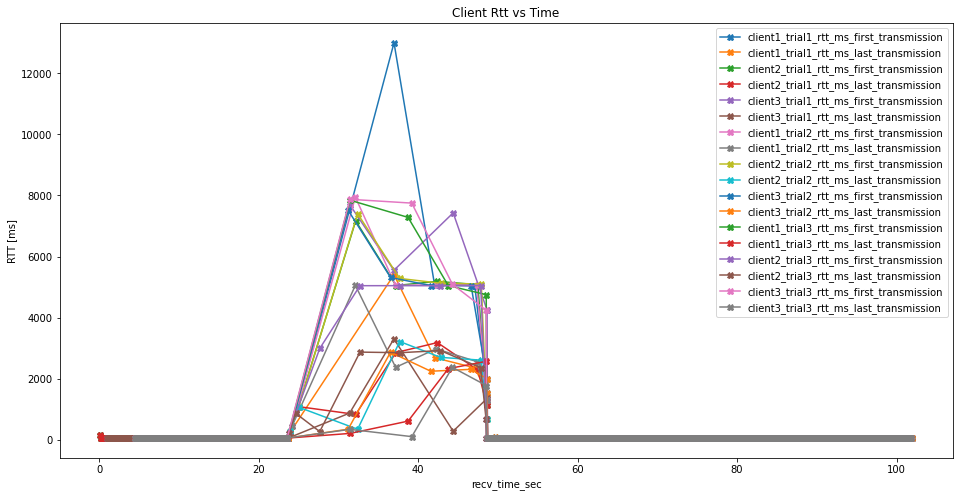

In [8]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "recv_time_sec",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = rtts_df[(rtts_df["trial"] == t) & (rtts_df["observer_id"] == c)]
        
        for rtt in rtts:
          label = f"{c}_trial{t}_{rtt}"
          ax = client_trial_df.plot(label=label, y=rtt, **plot_args, ax=ax)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

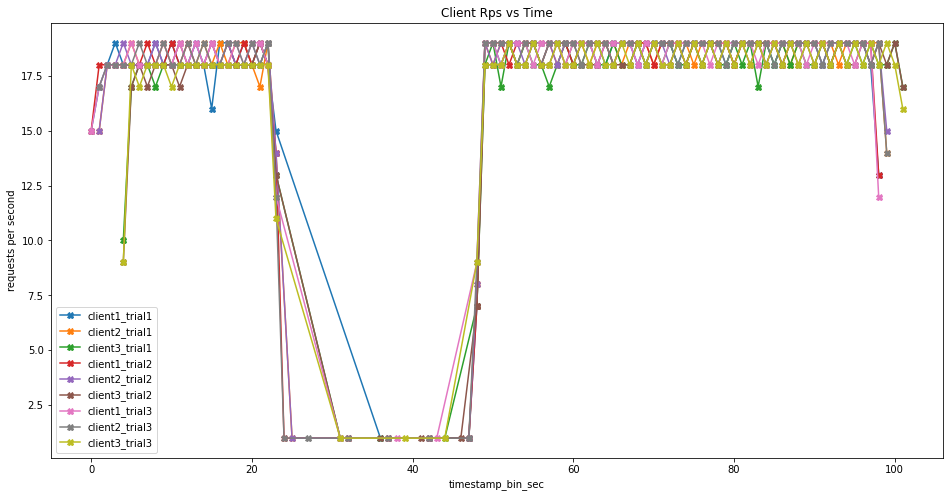

,timestamp_bin_sec,observer_id,packets_per_second
0,0.0,client1,15
1,1.0,client1,17
2,1.0,client2,17
3,2.0,client1,18
4,2.0,client2,18
...,...,...,...
231,98.0,client3,18
232,99.0,client2,14
233,99.0,client3,19
234,100.0,client3,18


In [9]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "timestamp_bin_sec",
    "y"     : "packets_per_second",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    trial_df = rtts_df[rtts_df["trial"] == t]
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "observer_id"]).agg(\
                                             packets_per_second=("average_rps", "count")).reset_index()
    
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = time_stats_df[time_stats_df["observer_id"] == c]
        
        label = f"{c}_trial{t}"
        ax = client_trial_df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

   trial   mean_rps
0      1  13.848095
1      2  13.874529
2      3  13.866146


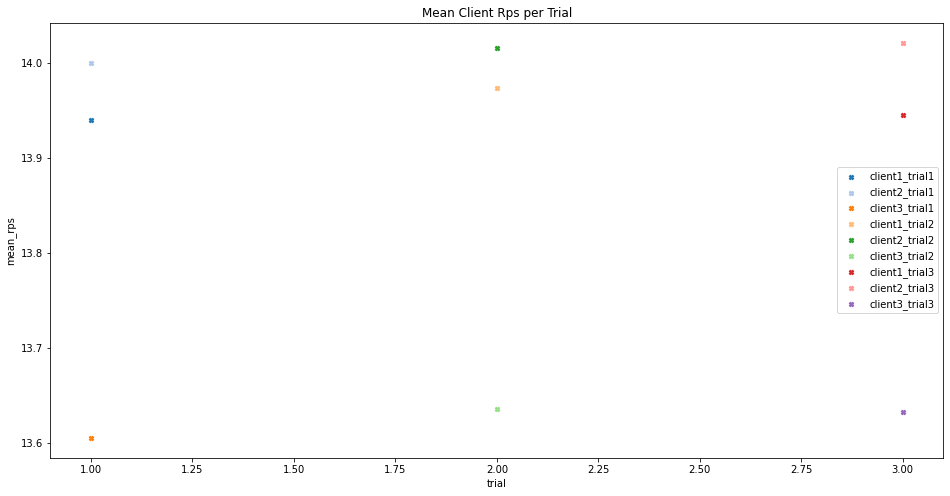

,observer_id,trial,mean_rps
0,client1,1,13.939716
1,client1,2,13.973283
2,client1,3,13.944885
3,client2,1,13.999737
4,client2,2,14.014923
5,client2,3,14.020971
6,client3,1,13.604832
7,client3,2,13.635380
8,client3,3,13.632582


In [10]:
per_trial_stats_df = (
  rtts_df
  .groupby(by=["observer_id", "trial"])
  .agg(
    mean_rps=("average_rps", "mean")
  )
  .reset_index()
)

plot_args = {
    "kind"  : "scatter",
    "x"     : "trial",
    "y"     : "mean_rps",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

colors = iter([plt.cm.tab20(i) for i in range(20)])

ax = None
for t in trials:
    for c in clients:
        
        grouped_client_trial_df = per_trial_stats_df[(per_trial_stats_df["trial"] == t) & (per_trial_stats_df["observer_id"] == c)]
        
        label = "hi"
        label=f"{c}_trial{t}"
        ax = grouped_client_trial_df.plot(ax=ax, label=label, color=[next(colors)], **plot_args)
        
print(per_trial_stats_df.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

per_trial_stats_df

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


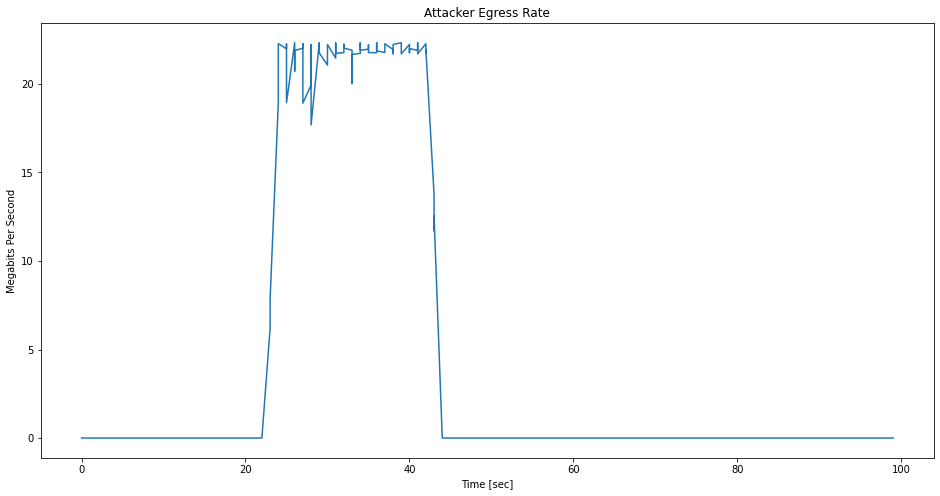

CPU times: user 332 ms, sys: 117 ms, total: 449 ms
Wall time: 1.7 s


,exp_id,expected_client_duration,trial,timestamp_bin,sum_bytes,num_messages,megabytes_per_second,megabits_per_second
0,multiclient_cloud_500mbps_attack_withattacker,100,1,0.0,0.0,0,0.0,0.0
1,multiclient_cloud_500mbps_attack_withattacker,100,1,1.0,0.0,0,0.0,0.0
2,multiclient_cloud_500mbps_attack_withattacker,100,1,2.0,0.0,0,0.0,0.0
3,multiclient_cloud_500mbps_attack_withattacker,100,1,3.0,0.0,0,0.0,0.0
4,multiclient_cloud_500mbps_attack_withattacker,100,1,4.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...
74,multiclient_cloud_500mbps_attack_withattacker,100,1,95.0,0.0,0,0.0,0.0
75,multiclient_cloud_500mbps_attack_withattacker,100,1,96.0,0.0,0,0.0,0.0
76,multiclient_cloud_500mbps_attack_withattacker,100,1,97.0,0.0,0,0.0,0.0
77,multiclient_cloud_500mbps_attack_withattacker,100,1,98.0,0.0,0,0.0,0.0


In [11]:
%%time

attack_rate_sql = f"""
WITH attacker_to_proxy AS (
  SELECT
    e.trial AS trial,
    e.observe_timestamp AS observe_timestamp,
    floor(e.observe_timestamp) AS timestamp_bin,
    e.message_marker AS message_marker,
    m.size_bytes AS size_bytes
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
  WHERE
    e.observer_id = {attacker_dnid} -- attacker dnid
    AND m.dst_id = {proxy_node_id}  -- proxy node id

), aggregations AS (
  SELECT
    trial,
    timestamp_bin,
    SUM(size_bytes) AS sum_bytes,
    COUNT(DISTINCT message_marker) AS num_messages
  FROM
    attacker_to_proxy
  GROUP BY
    trial, timestamp_bin
)

SELECT
  '{exp_id}' AS exp_id,
  {exp_config["client_duration"]} AS expected_client_duration,
  *,
  (1e-6 * sum_bytes) AS megabytes_per_second,
  (8 * 1e-6 * sum_bytes) AS megabits_per_second
FROM
  aggregations
ORDER BY
  timestamp_bin
"""
attack_rates_df = pd.read_sql_query(attack_rate_sql, con)

bins = list(range(max(attack_rates_df["expected_client_duration"])))
expected_client_duration = exp_config["client_duration"]

# Fill in the time where there is not an attack with zeros.
for trial in attack_rates_df.trial.unique():
  data = [{
    "exp_id": exp_id,
    "expected_client_duration": expected_client_duration, 
    "trial": trial, 
    "timestamp_bin": missing_timestamp, 
    "sum_bytes": 0.0,
    "num_messages": 0,
    "megabytes_per_second": 0.0,
    "megabits_per_second": 0.0,
  } for missing_timestamp in set(bins) - set(attack_rates_df.timestamp_bin.unique())]
  attack_rates_df = pd.concat([attack_rates_df, pd.DataFrame.from_records(data)])

attack_rates_df.sort_values(by="timestamp_bin", inplace=True)

ax = attack_rates_df.plot(kind="line", x="timestamp_bin", y="megabits_per_second")
ax.set_title("Attacker Egress Rate")
ax.set_ylabel("Megabits Per Second")
ax.set_xlabel("Time [sec]")
ax.get_legend().remove()
plt.show()

attack_rates_df

In [12]:
%%time

attack_dbg_sql = f"""
SELECT
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker,
	(ARRAY_AGG(cm_recv.coap_code))[1] AS coap_code,
	MIN(e_attacker_send.observe_timestamp) AS first_send_time_sec,
	1e3 * (MIN(e_proxy.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_proxy_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_proxy.observe_timestamp)) AS proxy_to_attacker_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_receiver_rtt_ms,
	MIN(e_attacker_recv.observe_timestamp) AS first_recv_time_sec
FROM
	event e_attacker_send
	JOIN deployed_node dn
		ON dn.dnid = e_attacker_send.observer_id
	JOIN message m_e_attacker_send
		ON m_e_attacker_send.message_id = e_attacker_send.message_id
	JOIN event e_proxy
		ON  e_proxy.trial          = e_attacker_send.trial
		AND e_proxy.message_marker = e_attacker_send.message_marker
	JOIN event e_attacker_recv
		ON  e_attacker_recv.trial          = e_proxy.trial
		AND e_attacker_recv.message_marker = e_proxy.message_marker
		JOIN message m_e_attacker_recv
			ON m_e_attacker_recv.message_id = e_attacker_recv.message_id
			JOIN coap_message cm_recv 
				ON cm_recv.cmci = m_e_attacker_recv.coap_message

WHERE
	e_attacker_send.observer_id      = {attacker_dnid} -- Sending attacker observer: dnid
		AND m_e_attacker_send.dst_id = {proxy_node_id} -- Attacker sends to proxy: node_id
	AND e_proxy.observer_id          = {proxy_dnid} -- Proxy observer: dnid
	AND e_attacker_recv.observer_id  = {attacker_message_receiver_dnid} -- Receiving attacker observer: dnid
		AND m_e_attacker_recv.dst_id = {attacker_message_receiver_node_id} -- Receiving attacker destination is attacker: node_id
GROUP BY
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker
;
"""

print(attack_dbg_sql)

attack_dbg_df = pd.read_sql_query(attack_dbg_sql, con)
attack_dbg_df.sort_values(by="first_send_time_sec", inplace=True)

attack_dbg_df


SELECT
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker,
	(ARRAY_AGG(cm_recv.coap_code))[1] AS coap_code,
	MIN(e_attacker_send.observe_timestamp) AS first_send_time_sec,
	1e3 * (MIN(e_proxy.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_proxy_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_proxy.observe_timestamp)) AS proxy_to_attacker_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_receiver_rtt_ms,
	MIN(e_attacker_recv.observe_timestamp) AS first_recv_time_sec
FROM
	event e_attacker_send
	JOIN deployed_node dn
		ON dn.dnid = e_attacker_send.observer_id
	JOIN message m_e_attacker_send
		ON m_e_attacker_send.message_id = e_attacker_send.message_id
	JOIN event e_proxy
		ON  e_proxy.trial          = e_attacker_send.trial
		AND e_proxy.message_marker = e_attacker_send.message_marker
	JOIN event e_attacker_recv
		ON  e_attacker_recv.trial          = e_proxy.trial
		AND e_a

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


CPU times: user 5.73 s, sys: 1.31 s, total: 7.04 s
Wall time: 21.7 s


,exp_id,trial,message_marker,coap_code,first_send_time_sec,attacker_to_proxy_ms,proxy_to_attacker_ms,attacker_to_receiver_rtt_ms,first_recv_time_sec
799173,multiclient_cloud_500mbps_attack_withattacker,3,1191,content,23.621520,-21.012068,66.818953,45.806885,23.667327
799174,multiclient_cloud_500mbps_attack_withattacker,3,1192,content,23.621584,-21.059036,76.215029,55.155993,23.676740
799175,multiclient_cloud_500mbps_attack_withattacker,3,1193,content,23.621646,-21.116972,74.062109,52.945137,23.674591
799176,multiclient_cloud_500mbps_attack_withattacker,3,1194,content,23.621720,-21.189213,78.378201,57.188988,23.678909
799172,multiclient_cloud_500mbps_attack_withattacker,3,1190,content,23.621769,-21.167994,68.175077,47.007084,23.668776
...,...,...,...,...,...,...,...,...,...
799166,multiclient_cloud_500mbps_attack_withattacker,2,513266,bad_gateway,43.626179,-21.337986,5031.010151,5009.672165,48.635851
799167,multiclient_cloud_500mbps_attack_withattacker,2,513267,bad_gateway,43.626217,-21.371126,5031.004190,5009.633064,48.635850
799168,multiclient_cloud_500mbps_attack_withattacker,2,513268,bad_gateway,43.626255,-21.317005,5030.915022,5009.598017,48.635853
799169,multiclient_cloud_500mbps_attack_withattacker,2,513269,bad_gateway,43.626293,-21.347046,5030.908823,5009.561777,48.635855


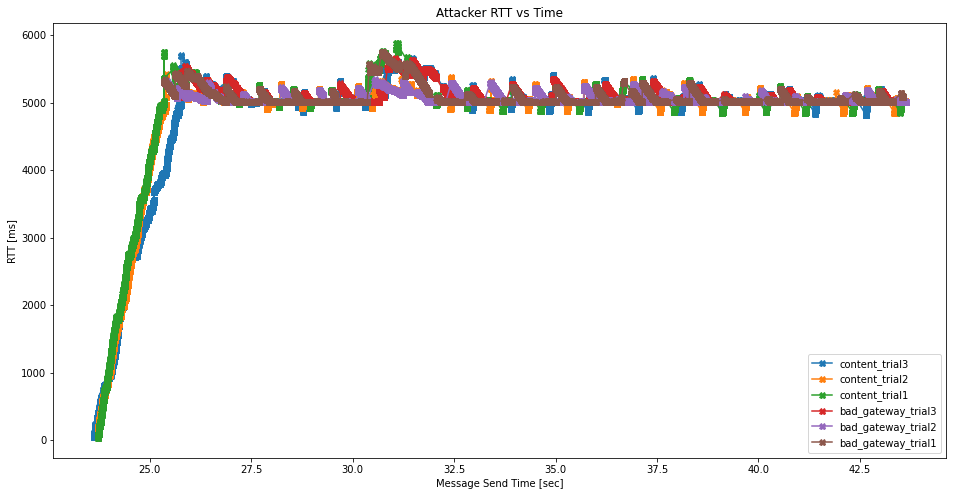

In [13]:
# Plot attacker rtt vs time

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "y": "attacker_to_receiver_rtt_ms",
  "marker": "X",
}

coap_codes = attack_dbg_df["coap_code"].unique()
trials = attack_dbg_df["trial"].unique()

ax = None
for coap_code in coap_codes:
    if coap_code is None:
        continue
    for t in trials:
      _df = attack_dbg_df[(attack_dbg_df["coap_code"] == coap_code) & (attack_dbg_df["trial"] == t)]
      label = f"{coap_code}_trial{t}"
      ax = _df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

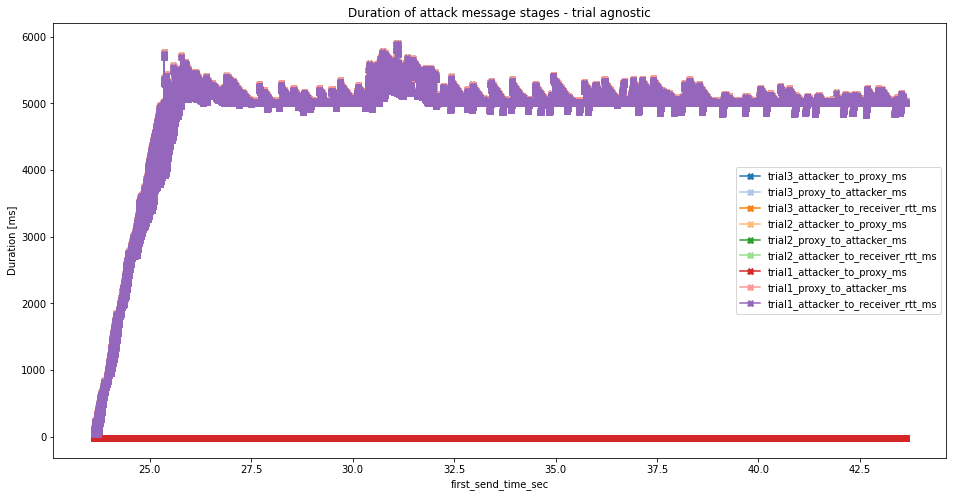

In [14]:
# Plot the duration of different stages of the attack messages

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "marker": "X",
}

colors = iter([plt.cm.tab20(i) for i in range(20)])

rtts = ["attacker_to_proxy_ms", "proxy_to_attacker_ms", "attacker_to_receiver_rtt_ms"]

ax = None
for t in trials:
  for rtt in rtts:
    label = f"trial{t}_{rtt}"
    ax = attack_dbg_df.plot(y=rtt, ax=ax, label=label, color=[next(colors)], **plot_args)

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()